# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [4]:
# Importamos librerías
from pandas_datareader import data as web
import pandas as pd
import numpy as np

In [5]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    closes = web.DataReader(tickers, start=start_date, end=end_date, data_source='yahoo')['Adj Close']
    closes = closes.sort_index()
    return closes

In [6]:
# Descargamos datos...
# Instrumento: Apple
name = ['AAPL']
# Fechas de interés (inicio y fin): 2010-2016
start = '2010-01-01'
end = '2016-12-31'
# Función DataReader
closes = get_closes(tickers=name,
                    start_date=start,
                    end_date=end)

In [10]:
closes.head()

Symbols,AAPL
Date,
2010-01-04,6.583586
2010-01-05,6.594968
2010-01-06,6.490066
2010-01-07,6.478067
2010-01-08,6.521136


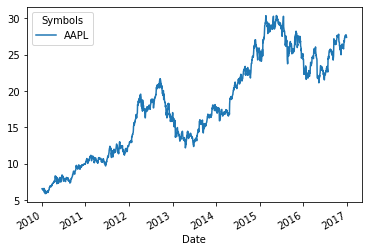

In [7]:
# Graficamos
closes.plot();

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [8]:
# Calcular rendimientos diarios y graficarlos
ret = closes.pct_change().dropna()

In [11]:
ret.head()

Symbols,AAPL
Date,
2010-01-05,0.001729
2010-01-06,-0.015906
2010-01-07,-0.001849
2010-01-08,0.006648
2010-01-11,-0.008821


In [12]:
len(ret)

1761

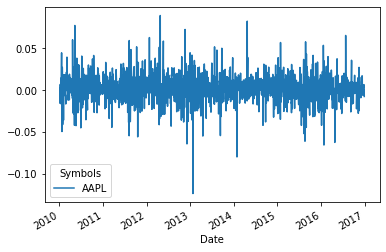

In [9]:
ret.plot();

Entonces, suponemos que la diferencia logaritmica de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [15]:
# Calculamos media y desviación estándar
mu = ret.mean()['AAPL']
sigma = ret.std()['AAPL']
mu, sigma

(0.000946043424708954, 0.016507169383872627)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2017 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios rendimientos diarios y que devuelva un dataframe con esta simulación.

In [16]:
# Ayuda en la función np.random.randn
help(np.random.randn)

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    .. note::
        New code should use the ``standard_normal`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
    
    Paramete

In [17]:
# Función que simula varios escenarios de rendimientos diarios
def ret_sim(mu, sigma, n_days, n_esc, start):
    dates = pd.date_range(start=start, periods=n_days)
    return pd.DataFrame(data=sigma * np.random.randn(n_days, n_esc) + mu, index=dates)

In [54]:
# Simulamos 100 escenarios para todo el 2017
n_esc = 1000000
n_days = 255
sim_ret = ret_sim(mu, sigma, n_days, n_esc, start='2017-01-01')
sim_ret.head()

,0,1,2,3,4,5,6,7,8,9,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
2017-01-01,0.036537,-0.005990,-0.016395,0.007986,0.005297,0.019306,-0.013699,-0.011789,0.024795,0.004934,...,-0.020908,-0.015728,0.004612,0.010736,-0.004749,0.009232,0.024915,0.023263,-0.002839,0.011655
2017-01-02,-0.001527,-0.003874,-0.014072,0.013740,-0.006203,-0.026455,0.008172,-0.004785,0.001172,-0.007976,...,0.010559,0.017211,0.000909,0.009722,0.010219,0.013265,0.009697,-0.007922,-0.015835,0.012817
2017-01-03,-0.012792,0.000097,0.009589,0.037698,0.000833,0.024115,0.003037,0.003182,-0.005037,0.007961,...,0.003544,-0.037546,-0.005589,0.001489,-0.006732,0.012166,0.009932,0.033082,0.018128,-0.012980
2017-01-04,0.033052,-0.001008,0.005649,-0.012305,-0.004740,0.012646,-0.001396,0.049358,-0.003362,-0.017953,...,-0.033124,-0.003309,0.008640,-0.008735,-0.001633,0.005835,0.012575,0.005049,-0.028284,0.028532
2017-01-05,-0.034045,0.002133,0.000679,-0.002243,0.002306,0.007379,0.014718,-0.029282,-0.019564,-0.030599,...,0.003357,0.000369,-0.003881,0.029838,0.001091,0.003877,-0.032864,0.033261,0.021127,0.010730


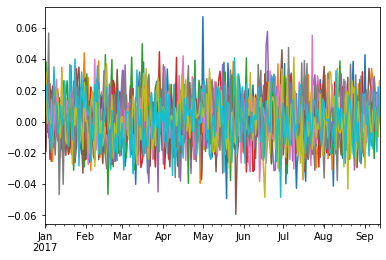

In [33]:
# Mostrar
#sim_ret.plot(legend=False);

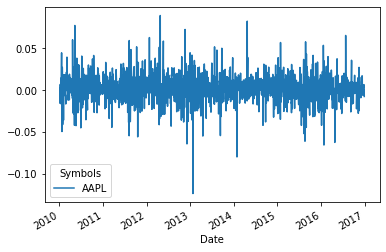

In [34]:
ret.plot();

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}\exp(r_0+\cdots+r_{k})$, donde $p_{-1}$ es el último precio reportado en el 2016.

Con los rendimientos, calculamos los precios de cierre...

In [35]:
closes.tail()

Symbols,AAPL
Date,
2016-12-23,27.547411
2016-12-27,27.722363
2016-12-28,27.604153
2016-12-29,27.597061
2016-12-30,27.381918


In [36]:
closes.loc['2016-12-27']

Symbols
AAPL    27.722363
Name: 2016-12-27 00:00:00, dtype: float64

In [37]:
closes.iloc[-1]

Symbols
AAPL    27.381918
Name: 2016-12-30 00:00:00, dtype: float64

In [55]:
# Obtenemos los precios
ultimo_precio = closes.iloc[-1]['AAPL']
sim_closes = ultimo_precio * (1 + sim_ret).cumprod()

In [56]:
sim_closes.head()

,0,1,2,3,4,5,6,7,8,9,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
2017-01-01,28.382384,27.217895,26.933004,27.600594,27.526958,27.910549,27.006819,27.059119,28.060862,27.517028,...,26.809413,26.951262,27.508201,27.675891,27.251893,27.634709,28.064130,28.018913,27.304192,27.701042
2017-01-02,28.339045,27.112455,26.554004,27.979823,27.356207,27.172175,27.227532,26.929651,28.093749,27.297552,...,27.092497,27.415108,27.533200,27.944960,27.530372,28.001297,28.336266,27.796956,26.871822,28.056081
2017-01-03,27.976543,27.115079,26.808640,29.034598,27.378999,27.827434,27.310231,27.015347,27.952242,27.514878,...,27.188508,26.385767,27.379324,27.986575,27.345025,28.341948,28.617694,28.716539,27.358968,27.691923
2017-01-04,28.901213,27.087739,26.960080,28.677334,27.249225,28.179344,27.272103,28.348781,27.858264,27.020897,...,26.287916,26.298463,27.615876,27.742125,27.300378,28.507322,28.977550,28.861519,26.585149,28.482022
2017-01-05,27.917257,27.145517,26.978377,28.613010,27.312053,28.387288,27.673498,27.518679,27.313249,26.194079,...,26.376166,26.308179,27.508694,28.569882,27.330149,28.617833,28.025242,29.821493,27.146805,28.787621


Concatenamos y graficamos...

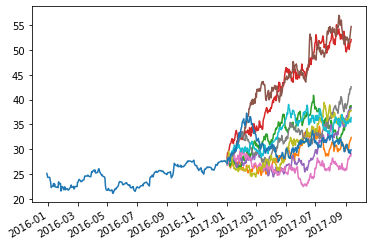

In [40]:
# Concatenar y graficar
#sim_closes_cat = pd.concat([closes.iloc[-255:], sim_closes])
#sim_closes_cat.plot(legend=False);

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [59]:
# Umbral de 10% del ultimo precio
umbral = 1.15 * ultimo_precio
# Fechas
dates = sim_ret.index
# DataFrame de Strikes
umbrales = pd.DataFrame(index=dates, data=umbral * np.ones(len(dates)))
# Concatenar y graficar
#sim_closes_cat_strikes = pd.concat([sim_closes_cat.T, umbrales.T]).T
#sim_closes_cat_strikes.plot(legend=False);

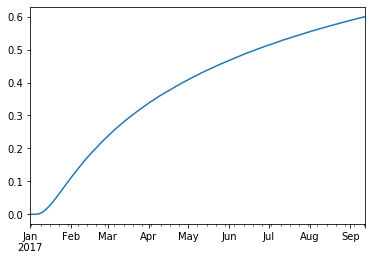

In [60]:
# Comparar cada escenario en cada fecha
conteo = sim_closes > umbral
# Sumamos para cada fecha y dividimos entre el número de escenarios
prob_est = conteo.sum(axis=1) / n_esc
# Gráfico de probabilidad
prob_est.plot();

In [62]:
closes_AAPL_2017 = get_closes(tickers=['AAPL'],
                              start_date='2017-01-01',
                              end_date='2017-12-31')

In [64]:
umbral

31.48920564651489

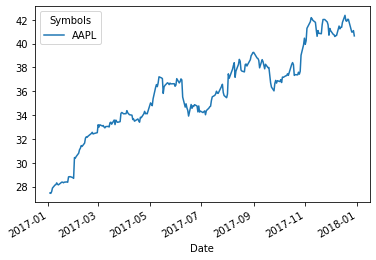

In [63]:
closes_AAPL_2017.plot();

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>